In [1]:
pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification

In [3]:
# ----------------------------
# Guided Backpropagation ReLU
# ----------------------------
class GuidedBackpropReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        positive_mask = (input > 0).type_as(input)
        ctx.save_for_backward(positive_mask)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        positive_mask, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[positive_mask == 0] = 0
        grad_output[grad_output < 0] = 0
        return grad_input * positive_mask

# Custom ReLU module
class GuidedReLU(nn.Module):
    def forward(self, x):
        return GuidedBackpropReLU.apply(x)

# ----------------------------
# Hook to capture gradients
# ----------------------------
def register_hooks(model, layer_name):
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    # Navigate to the desired layer
    submodule = model
    for part in layer_name.split('.'):
        if part.isdigit():
            submodule = submodule[int(part)]
        else:
            submodule = getattr(submodule, part)

    submodule.register_forward_hook(forward_hook)
    submodule.register_backward_hook(backward_hook)

    return activations, gradients

# ----------------------------
# Guided Backpropagation Logic
# ----------------------------
def guided_backprop(model, input_tensor, layer_name, feature_index):
    model.eval()
    input_tensor.requires_grad = True

    activations, gradients = register_hooks(model, layer_name)

    # Forward pass
    model.zero_grad()
    output = model(input_tensor)

    # Extract the activation of the selected layer
    feature = activations['value'][0, feature_index]
    feature_mean = feature.mean()  # scalar to backpropagate

    # Backward pass
    feature_mean.backward()

    # Guided gradient wrt input
    guided_gradients = input_tensor.grad[0].cpu().numpy()
    return guided_gradients

# ----------------------------
# Utility: Preprocess image
# ----------------------------
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]    # ImageNet std
        )
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# ----------------------------
# Utility: Visualize gradients
# ----------------------------
def visualize_gradient(grad):
    grad = grad.transpose(1, 2, 0)  # CHW -> HWC
    grad -= grad.min()
    grad /= grad.max()
    plt.imshow(grad)
    plt.axis('off')
    plt.title("Guided Backpropagation")
    plt.show()

layer_name='layer4.2.conv3'
feature_index=10

# Modify model for guided backprop
for name, module in model.named_children():
    if isinstance(module, nn.ReLU):
        setattr(model, name, GuidedReLU())
    else:
        replace_relu_with_guided_relu(module)

# Perform guided backpropagation
guided_grad = guided_backprop(model, img, layer_name, feature_index)

# Visualize
visualize_gradient(guided_grad)

Downloading...
From: https://drive.google.com/uc?id=1VG4038s0Z5lvJ_99l--YMsM2KZg0FWaK
To: /content/img_dog.jpg
100% 10.2k/10.2k [00:00<00:00, 20.3MB/s]


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


torch.Size([1, 3, 224, 224])


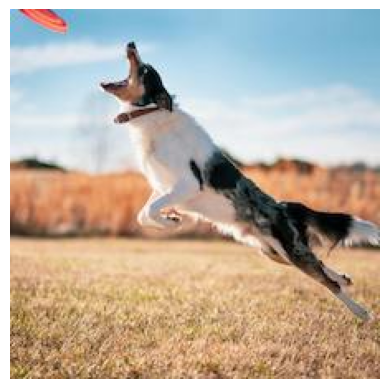

In [4]:
# Different image download: https://drive.google.com/file/d/1HTm5iC6If3VObOHsiR_36Cwt8BqaFhMV/view?usp=sharing
!gdown 1VG4038s0Z5lvJ_99l--YMsM2KZg0FWaK
img = np.asarray(Image.open('/content/img_dog.jpg'))
imgplot = plt.imshow(img)
plt.axis('off')

# to PyTorch/ImageNet (dataset with 1000 classes) format
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])

img = transform(img) # transform to right format for model
img = img.to('cuda:0') # to cpu / gpu (cuda:0)
img = img.unsqueeze(0) # Shape 1,3,224,224 (Batch,Channel,Height,Weight)
print(img.shape)

In [7]:
def huggingfaceTransformer_to_torchvision(hf_model):
    # Init new torchvision model
    tv_model = models.resnet50()
    tv_model.fc = nn.Linear(tv_model.fc.in_features, hf_model.config.num_labels)

    # Align parameter names
    hf_keys = list(hf_model.state_dict().keys())
    tv_keys = list(tv_model.state_dict().keys())

    # Create a mapping from HF keys to TV keys
    key_mapping = {}
    for hf_key in hf_keys:
        # This is a simplified mapping and might need adjustment based on the specific models
        # and how they are structured.
        tv_key = hf_key.replace('resnet.encoder.stages.', 'layer').replace('.layers.0', '').replace('resnet.embedder.embedder.', '').replace('convolution', 'conv').replace('normalization', 'bn').replace('.0.', '.').replace('.1.', '.').replace('.2.', '.').replace('.3.', '.').replace('.4.', '.').replace('.5.', '.')
        if 'classifier' in hf_key:
            tv_key = 'fc.' + hf_key.split('.')[-1]
        if tv_key in tv_keys:
            key_mapping[hf_key] = tv_key
            print(f"Mapped HF key {hf_key} to TV key {tv_key}.")
        else:
            print(f"Could not map HF key: {hf_key} to TV key.")


    new_hf_state = {}
    for k, v in hf_model.state_dict().items():
        if k in key_mapping:
            new_hf_state[key_mapping[k]] = v

    # Load the state dictionary with strict=False to ignore missing keys that are not in the filtered dict
    tv_model.load_state_dict(new_hf_state, strict=False)

    return tv_model

In [8]:
# Load TV base model
base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
base_model = base_model.to('cuda:0')
base_model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Load HF models
hf_base_model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50"
).to('cuda:0')
base_model_HFref = huggingfaceTransformer_to_torchvision(hf_base_model).to('cuda:0')

hf_ft_model = AutoModelForImageClassification.from_pretrained(
    "phuong-tk-nguyen/resnet-50-finetuned-cifar10"
    #cppgohan/resnet-50-finetuned-dog-vs-cat
).to('cuda:0')
ft_model = huggingfaceTransformer_to_torchvision(hf_ft_model).to('cuda:0')

Could not map HF key: resnet.embedder.embedder.convolution.weight to TV key.
Could not map HF key: resnet.embedder.embedder.normalization.weight to TV key.
Could not map HF key: resnet.embedder.embedder.normalization.bias to TV key.
Could not map HF key: resnet.embedder.embedder.normalization.running_mean to TV key.
Could not map HF key: resnet.embedder.embedder.normalization.running_var to TV key.
Could not map HF key: resnet.embedder.embedder.normalization.num_batches_tracked to TV key.
Could not map HF key: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight to TV key.
Could not map HF key: resnet.encoder.stages.0.layers.0.shortcut.normalization.weight to TV key.
Could not map HF key: resnet.encoder.stages.0.layers.0.shortcut.normalization.bias to TV key.
Could not map HF key: resnet.encoder.stages.0.layers.0.shortcut.normalization.running_mean to TV key.
Could not map HF key: resnet.encoder.stages.0.layers.0.shortcut.normalization.running_var to TV key.
Could not map HF ke

In [10]:
hf_ft_model.eval()

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [11]:
def compare_model_weights(model1, model2, sort=True, exclude_layers=[]):
    weight_differences = {}
    for name, param in model1.named_parameters():
        # Exclude specified layers
        if any(ex_layer in name for ex_layer in exclude_layers):
            continue

        if name in model2.state_dict():
            diff = torch.norm(param.data - model2.state_dict()[name].data)
            weight_differences[name] = diff.item()
        else:
            print(f"Parameter '{name}' not found in the second model")

    if sort: weight_differences = sorted(weight_differences.items(), key=lambda item: item[1], reverse=True)

    return weight_differences

In [12]:
weight_diffs = compare_model_weights(base_model_HFref, ft_model, sort=True, exclude_layers=['fc'])
for name, diff in weight_diffs:
    if diff > 0:
        print(f"Weight difference for '{name}': {diff}")

Weight difference for 'layer4.1.conv1.weight': 90.50767517089844
Weight difference for 'layer4.2.conv1.weight': 90.46163940429688
Weight difference for 'layer3.2.conv1.weight': 64.12784576416016
Weight difference for 'layer3.5.conv1.weight': 64.11095428466797
Weight difference for 'layer4.0.conv1.weight': 64.07438659667969
Weight difference for 'layer4.0.downsample.0.weight': 64.01982116699219
Weight difference for 'layer3.1.conv1.weight': 63.9756965637207
Weight difference for 'layer3.3.conv1.weight': 63.908416748046875
Weight difference for 'layer3.4.conv1.weight': 63.798885345458984
Weight difference for 'layer3.0.downsample.0.weight': 45.30746078491211
Weight difference for 'layer4.2.conv3.weight': 45.30565643310547
Weight difference for 'layer3.0.conv1.weight': 45.30048751831055
Weight difference for 'layer2.3.conv1.weight': 45.299259185791016
Weight difference for 'layer4.1.conv3.weight': 45.266815185546875
Weight difference for 'layer2.2.conv1.weight': 45.26136779785156
Weight d

In [36]:
output_base = base_model(img)
prediction_base = output_base.argmax(dim=1).item()
output_class_base = output_base[0, prediction_base].item()

print(f"Base Model Prediction: {prediction_base}")
print(f"Base Model Output for predicted class: {output_class_base}")

output_base_HFref = base_model_HFref(img)
prediction_base_HFref = output_base_HFref.argmax(dim=1).item()
output_class_base_HFref = output_base_HFref[0, prediction_base_HFref].item()

print(f"Base Model (HF Ref) Prediction: {prediction_base_HFref}")
print(f"Base Model (HF Ref) Output for predicted class: {output_class_base_HFref}")

output_ft = ft_model(img)
prediction_ft = output_ft.argmax(dim=1).item()
output_class_ft = output_ft[0, prediction_ft].item()

print(f"Fine-tuned Model Prediction: {prediction_ft}")
print(f"Fine-tuned Output for predicted class: {output_class_ft}")

output_base_hf = hf_base_model(img)
prediction_base_hf = output_base_hf.logits.argmax().item()
output_class_base_hf = output_base_hf.logits[0, prediction_base_hf].item()

print(f"Base Model (HF) Prediction: {prediction_base_hf}")
print(f"Base Model (HF) Output for predicted class: {output_class_base_hf}")

output_ft_hf = hf_ft_model(img)
prediction_ft_hf = output_ft_hf.logits.argmax().item()
output_class_ft_hf = output_ft_hf.logits[0, prediction_ft_hf].item()

print(f"Fine-tuned Model (HF) Prediction: {prediction_ft_hf}")
print(f"Fine-tuned Model (HF) Output for predicted class: {output_class_ft_hf}")

Base Model Prediction: 232
Base Model Output for predicted class: 5.592793941497803
Base Model (HF Ref) Prediction: 600
Base Model (HF Ref) Output for predicted class: -148.11798095703125
Fine-tuned Model Prediction: 8
Fine-tuned Output for predicted class: 0.1474439650774002
Base Model (HF) Prediction: 232
Base Model (HF) Output for predicted class: -0.34962940216064453
Fine-tuned Model (HF) Prediction: 8
Fine-tuned Model (HF) Output for predicted class: 3.044161319732666


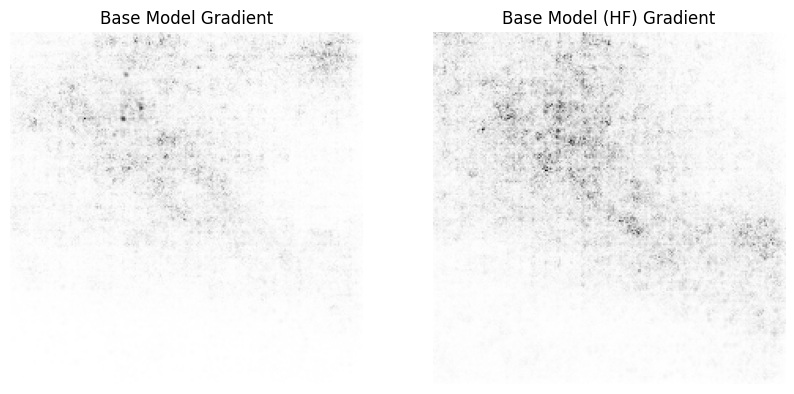

In [53]:
# Vanilla Gradient
img.requires_grad = True # make sure that gradient computation for the input is active
output_base = base_model(img)
prediction_base = output_base.argmax(dim=1).item()
prediction_output = torch.gather(output_base, 1, torch.tensor([prediction_base]).unsqueeze(-1).to(output_base.device)) # get output node at predicted index
gradients = torch.autograd.grad(prediction_output, img, create_graph=False)[0] # compute gradient
gradients_plot_base = gradients[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot_base = gradients_plot_base / gradients_plot_base.max()

img.requires_grad = True # make sure that gradient computation for the input is active
output_base_hf = hf_base_model(img)
prediction_base_hf = output_base_hf.logits.argmax().item()
prediction_output = torch.gather(output_base_hf.logits, 1, torch.tensor([prediction_base_hf]).unsqueeze(-1).to(output_base_hf.logits.device)) # get output node at predicted index
gradients = torch.autograd.grad(prediction_output, img, create_graph=False)[0] # compute gradient
gradients_plot_base_hf = gradients[0].abs().sum(dim=0).detach().cpu().numpy()
gradients_plot_base_hf = gradients_plot_base_hf / gradients_plot_base_hf.max()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gradients_plot_base, cmap='binary', vmin = 0, vmax = 1)
plt.title("Base Model Gradient")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradients_plot_base_hf, cmap='binary', vmin = 0, vmax = 1)
plt.title("Base Model (HF) Gradient")
plt.axis('off')

plt.show()